Explorando un modelo de diffusion
==================================

Veamos un ejemplo de cómo ejecutar un modelo de difusión para generar imágenes no condicionadas (unconditioned image generation).

## Preparación del ambiente

In [1]:
%pip install diffusers accelerate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.9 MB/s eta 0:00:00



## Entendiendo la libería diffusers

Hasta el momento, solo hemos utilizado de HuggingFace🤗 la librería `transformers`. Sin embargo, también proveen otras librerias como ser `diffusers`.

Diffusers es una librería que permite utilizar modelos generativos para imágenes, audio, e incluso estructuras más complejas como 3D.


### Componentes

La librería se construye sobre 2 conceptos importantes:

- Modelo: Dada una imagen X con una dada cantidad de ruido, el modelo genera una nueva imagen de iguales dimensiones pero con las predicciones de los residuales del ruido (noise residuals).
- Programador (Scheduler): Dada una cantidad de pasos N, el programador planifica realizar N pasadas sobre el modelo, utilizando sobre cada iteración el resultado de la iteración pasada. El planificador aqui intenta predecir una imagen eliminando el ruido que fue generado anteriormente.


Construyamos nuestro proceso de generación:





In [2]:
model_name = "google/ddpm-cat-256"

Cargemos estos 2 componentes utilizando la librería difussers. Los modelos de diffuser son bastante costosos, por lo que tendremos mejor performance si los ejecutamos sobre una GPU:

In [3]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained(model_name)
model = UNet2DModel.from_pretrained(model_name, low_cpu_mem_usage=False).to("cuda")

## Generando una imagen no condicionada

Comenzaremos por generar una imagén con ruido aleatorio:

In [4]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")

In [5]:
noise.shape

torch.Size([1, 3, 256, 256])

> Note aquí que estamos utilizando imágenes con la modalidad "channel first", es decir que el numero de canales está adelante de las dimensiones de la imagen. Los DMs en general utilizan esta convención.

Podemos probar el modelo como sigue:

In [6]:
noisy_residual = model(noise, 0).sample
noisy_residual.shape

torch.Size([1, 3, 256, 256])

Configuremos la cantidad de pasos de *denoising*:

In [7]:
scheduler.set_timesteps(50)

Ahora, generemos un bucle para iterar sobre los pasos de generacion. En cada paso, el modelo realiza una pasada UNet2DModel.forward() y devuelve el residuo del ruido. 

El método `step()` del programador toma el ruido residual, el paso y la entrada y predice la imagen en el paso anterior, pero con menos ruido. Esta salida se convierte en la siguiente entrada en el ciclo de eliminación de ruido y se repetirá hasta el final.

In [8]:
previous_noisy_sample = noise

In [9]:
from tqdm import tqdm

for t in tqdm(scheduler.timesteps):
  with torch.no_grad():
    # Pred
    noisy_residual = model(previous_noisy_sample, t).sample

  previous_noisy_sample = scheduler.step(noisy_residual, t, previous_noisy_sample).prev_sample

100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


Finalmente debemos convertir la salida del modelo en una imagen:

In [10]:
from PIL import Image
import numpy as np

Primero denormalizamos la salida, obtenemos valores enteros de 0 a 255:

In [11]:
image = ((previous_noisy_sample / 2 + 0.5).clamp(0, 1) * 255).round().type(torch.uint8)

Nuestros tensores tienen una configuración "channel first". En general, las librerias de imágenes usan "channel last".

In [12]:
image_channel_last = image.cpu().permute(0,2,3,1)

Nos quedamos con una de las imagenes del lote:

In [13]:
image_sample = image_channel_last.numpy()[0]

Construimos la imagen:

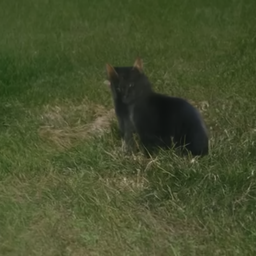

In [14]:
image = Image.fromarray(image_sample)
image

Para simplicidad, pongamos este código en una rutina que convierta la salida del proceso de denoising en una imagen lista para usar:

In [ ]:
def image_from_output(denoised_image):
  image = ((denoised_image / 2 + 0.5).clamp(0, 1) * 255).round().type(torch.uint8)
  image = image.cpu().permute(0,2,3,1)
  image = image_channel_last.numpy()[0]
  
  return Image.fromarray(image)

## Pipelines en la libreria diffusers

En el ejemplo anterior, vimos como ejecutar un proceso de diffusion sencillo, aunque completo. Estos procesos están implementados en la libería diffusers en lo que se conocen como `pipeline`. Ya hemos utilizado pipelines cuando trabajamos con transformers anteriormente.

Existen diferentes tipos de pipelines, cada uno dependiendo en general del tipo de scheduler que se requiere y, por consiguiente, el tipo de DM. Recuerde que el scheduler es el component que gobierna el proceso de generación de punta a punta. 

El equivalente al que estuvimos utilizando aqui es `DDPMPipeline`.

In [15]:
from diffusers import DDPMPipeline

In [21]:
dm = DDPMPipeline.from_pretrained(model_name).to("cuda")

Una vez que tenemos el pipeline cargado, podemos ejecutar su proceso de generación:

In [23]:
samples = dm(num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]

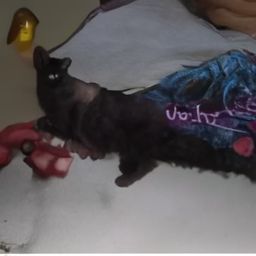

In [26]:
samples.images[0]

Note que en todos estos ejemplos generativos, no tenemos control sobre que es lo que el DM termina generando. Es por esto que el proceso se conoce como *unconditioned image generation*. Veremos en el siguiente ejemplo como podemos utilizar un modelo que puede ser condicionado durante su proceso generativo.